# Sentiment Analysis

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
import seaborn as sns

OHCO = ['album_id', 'song_num', 'stanza_num', 'line_num', 'token_num']
colors = 'YlGnBu'
salex_csv = '../../lexicons/salex_nrc.csv'
emo_cols = "anger anticipation disgust fear joy sadness surprise trust sentiment".split()

## Read Data

In [2]:
LIB = pd.read_csv('../tables/LIB.csv', sep='|').set_index('album_id')
SONG_LIB = pd.read_csv('../tables/SONG_LIB', sep='|').set_index(['album_id', 'song_num'])
CORPUS = pd.read_csv('../tables/CORPUS.csv', sep='|').set_index(OHCO)
VOCAB = pd.read_csv('../tables/VOCAB.csv', sep='|').set_index('term_str')
BOW_SONG = pd.read_csv('../tables/BOW_SONG.csv', sep='|').set_index(['album_id', 'song_num', 'term_str'])
BOW_ALBUM = pd.read_csv('../tables/BOW_ALBUM.csv', sep='|').set_index(['album_id', 'term_str'])
TFIDF_ALBUM = pd.read_csv('../tables/TFIDF_ALBUM.csv', sep='|').set_index(OHCO[:1])
TFIDF_SONG = pd.read_csv('../tables/TFIDF_SONG.csv', sep='|').set_index(OHCO[:2])

In [3]:
VOCAB = VOCAB.drop_duplicates()

## Setup

In [4]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]

In [5]:
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


## Combine `SALEX` with `VOCAB`

In [6]:
VOCAB_SENT = VOCAB.join(SALEX, how='inner')

In [7]:
VOCAB_SENT

,n,n_chars,p,i,max_pos,max_pos_group,stop,porter_stem,song_dfidf,album_dfidf,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,sentiment
term_str,,,,,,,,,,,,,,,,,,,,,
abandon,2,7,0.000010,16.555301,NNP,NN,0,abandon,17.792665,10.951467,...,0,0,1,0,1,0,1,0,0,-1
abandoned,1,9,0.000005,17.555301,VBD,VB,0,abandon,9.896332,6.475733,...,0,0,1,0,1,0,1,0,0,-1
absence,6,7,0.000031,14.970338,NN,NN,0,absenc,37.872022,20.769027,...,0,0,1,0,1,0,1,0,0,-1
absentee,2,8,0.000010,16.555301,NN,NN,0,absente,9.896332,6.475733,...,0,0,0,0,1,0,1,0,0,-1
abundance,1,9,0.000005,17.555301,NN,NN,0,abund,9.896332,6.475733,...,1,1,0,1,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
words,72,5,0.000374,11.385376,NNS,NN,0,word,201.147441,46.914821,...,0,0,0,0,1,0,0,0,0,-1
worn,2,4,0.000010,16.555301,VBN,VB,0,worn,17.792665,10.951467,...,0,0,0,0,1,0,1,0,0,-1
worse,29,5,0.000151,12.697320,JJR,JJ,0,wors,75.736439,33.179320,...,0,0,1,0,1,0,1,0,0,-1


## Merge `VOCAB` with `BOW_ALBUM`

In [8]:
BOW_SENT_ALBUM = BOW_ALBUM.join(VOCAB_SENT[['max_pos', 'album_dfidf'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [9]:
BOW_SENT_ALBUM

n     tfidf max_pos  album_dfidf  anger  anticipation  \
album_id term_str                                                           
0        afraid     2  0.108454      JJ    44.899944    0.0           0.0   
         beautiful  2  0.119656      JJ    43.076107    0.0           0.0   
         favorite   2  0.167572      JJ    33.179320    0.0           0.0   
         ill        4  0.027435     NNP    18.518606    1.0           0.0   
         late       4  0.179750      JJ    46.914821    0.0           0.0   
...                ..       ...     ...          ...    ...           ...   
88       wear       1  0.016144     VBP    42.328312    0.0           0.0   
         wild       1  0.014611      JJ    44.358640    0.0           0.0   
         winner     1  0.030100     NNP    20.769027    0.0           1.0   
         worse      1  0.021857     JJR    33.179320    0.0           0.0   
         youth      1  0.023955      NN    29.752276    1.0           1.0   

                    disgust  fear  joy  sadness  surprise  trust  sentiment  
album_id term_str                                                            
0        afraid         0.0   1.0  0.0      0.0       0.0    0.0       -1.0  
         beautiful      0.0   0.0  1.0      0.0       0.0    0.0        1.0  
         favorite       0.0   0.0  1.0      0.0       0.0    1.0        1.0  
         ill            1.0   1.0  0.0      1.0       0.0    0.0       -1.0  
         late           0.0   0.0  0.0      1.0       0.0    0.0       -1.0  
...                     ...   ...  ...      ...       ...    ...        ...  
88       wear           0.0   0.0  0.0      0.0       0.0    1.0       -1.0  
         wild           0.0   0.0  0.0      0.0       1.0    0.0       -1.0  
         winner         0.0   0.0  1.0      0.0       1.0    0.0        1.0  
         worse          0.0   1.0  0.0      1.0       0.0    0.0       -1.0  
         youth          0.0   1.0  1.0      0.0       1.0    0.0        1.0  

[3179 rows x 13 columns]

### Add Album TF-IDF to B for weighting emotions

In [10]:
tfidf = TFIDF_ALBUM.stack().to_frame()

In [11]:
tfidf.columns = ['tfidf']
tfidf.index = tfidf.index.rename(['album_id', 'term_str'])

In [12]:
tfidf

tfidf
album_id term_str       
0        1           0.0
         10cc        0.0
         10th        0.0
         1st         0.0
         2           0.0
...                  ...
88       еh          0.0
         еnding      0.0
         еye         0.0
         政権の腐敗       0.0
         政権の腐敗敗      0.0

[810790 rows x 1 columns]

In [13]:
BOW_SENT_ALBUM

n     tfidf max_pos  album_dfidf  anger  anticipation  \
album_id term_str                                                           
0        afraid     2  0.108454      JJ    44.899944    0.0           0.0   
         beautiful  2  0.119656      JJ    43.076107    0.0           0.0   
         favorite   2  0.167572      JJ    33.179320    0.0           0.0   
         ill        4  0.027435     NNP    18.518606    1.0           0.0   
         late       4  0.179750      JJ    46.914821    0.0           0.0   
...                ..       ...     ...          ...    ...           ...   
88       wear       1  0.016144     VBP    42.328312    0.0           0.0   
         wild       1  0.014611      JJ    44.358640    0.0           0.0   
         winner     1  0.030100     NNP    20.769027    0.0           1.0   
         worse      1  0.021857     JJR    33.179320    0.0           0.0   
         youth      1  0.023955      NN    29.752276    1.0           1.0   

                    disgust  fear  joy  sadness  surprise  trust  sentiment  
album_id term_str                                                            
0        afraid         0.0   1.0  0.0      0.0       0.0    0.0       -1.0  
         beautiful      0.0   0.0  1.0      0.0       0.0    0.0        1.0  
         favorite       0.0   0.0  1.0      0.0       0.0    1.0        1.0  
         ill            1.0   1.0  0.0      1.0       0.0    0.0       -1.0  
         late           0.0   0.0  0.0      1.0       0.0    0.0       -1.0  
...                     ...   ...  ...      ...       ...    ...        ...  
88       wear           0.0   0.0  0.0      0.0       0.0    1.0       -1.0  
         wild           0.0   0.0  0.0      0.0       1.0    0.0       -1.0  
         winner         0.0   0.0  1.0      0.0       1.0    0.0        1.0  
         worse          0.0   1.0  0.0      1.0       0.0    0.0       -1.0  
         youth          0.0   1.0  1.0      0.0       1.0    0.0        1.0  

[3179 rows x 13 columns]

In [14]:
BOW_SENT_ALBUM.head()

n     tfidf max_pos  album_dfidf  anger  anticipation  \
album_id term_str                                                           
0        afraid     2  0.108454      JJ    44.899944    0.0           0.0   
         beautiful  2  0.119656      JJ    43.076107    0.0           0.0   
         favorite   2  0.167572      JJ    33.179320    0.0           0.0   
         ill        4  0.027435     NNP    18.518606    1.0           0.0   
         late       4  0.179750      JJ    46.914821    0.0           0.0   

                    disgust  fear  joy  sadness  surprise  trust  sentiment  
album_id term_str                                                            
0        afraid         0.0   1.0  0.0      0.0       0.0    0.0       -1.0  
         beautiful      0.0   0.0  1.0      0.0       0.0    0.0        1.0  
         favorite       0.0   0.0  1.0      0.0       0.0    1.0        1.0  
         ill            1.0   1.0  0.0      1.0       0.0    0.0       -1.0  
         late           0.0   0.0  0.0      1.0       0.0    0.0       -1.0

## Weight emotions by TFIDF

In [15]:
for col in emo_cols:
    BOW_SENT_ALBUM[col] = BOW_SENT_ALBUM[col] * BOW_SENT_ALBUM.tfidf

In [16]:
BOW_SENT_ALBUM.head()

n     tfidf max_pos  album_dfidf     anger  anticipation  \
album_id term_str                                                              
0        afraid     2  0.108454      JJ    44.899944  0.000000           0.0   
         beautiful  2  0.119656      JJ    43.076107  0.000000           0.0   
         favorite   2  0.167572      JJ    33.179320  0.000000           0.0   
         ill        4  0.027435     NNP    18.518606  0.027435           0.0   
         late       4  0.179750      JJ    46.914821  0.000000           0.0   

                     disgust      fear       joy   sadness  surprise  \
album_id term_str                                                      
0        afraid     0.000000  0.108454  0.000000  0.000000       0.0   
         beautiful  0.000000  0.000000  0.119656  0.000000       0.0   
         favorite   0.000000  0.000000  0.167572  0.000000       0.0   
         ill        0.027435  0.027435  0.000000  0.027435       0.0   
         late       0.000000  0.000000  0.000000  0.179750       0.0   

                       trust  sentiment  
album_id term_str                        
0        afraid     0.000000  -0.108454  
         beautiful  0.000000   0.119656  
         favorite   0.167572   0.167572  
         ill        0.000000  -0.027435  
         late       0.000000  -0.179750

## Compute Doc (`ALBUM`) sentiment 

In [17]:
ALBUM_SENT = BOW_SENT_ALBUM.groupby('album_id').agg({
    'anger':'mean',
    'anticipation':'mean',
    'disgust':'mean',
    'fear':'mean',
    'joy':'mean',
    'sadness':'mean',
    'surprise':'mean',
    'trust':'mean',
    'sentiment':'mean'
})

In [18]:
ALBUM_SENT

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment
album_id,,,,,,,,,
0,0.020283,0.063275,0.002494,0.018841,0.087754,0.036624,0.014451,0.018960,0.041270
1,0.021601,0.017820,0.026309,0.025889,0.036120,0.030183,0.017985,0.041885,-0.010675
2,0.016871,0.013524,0.002137,0.019329,0.024516,0.014734,0.009189,0.025015,0.000084
3,0.012333,0.013142,0.007488,0.012699,0.019197,0.015426,0.004752,0.018300,-0.022830
4,0.003188,0.008878,0.010771,0.110125,0.012022,0.135939,0.001276,0.012614,-0.083888
...,...,...,...,...,...,...,...,...,...
84,0.004510,0.003981,0.002295,0.006680,0.008632,0.007947,0.004917,0.006379,-0.001033
85,0.009039,0.007002,0.005170,0.012388,0.006133,0.014131,0.006676,0.006021,-0.012934
86,0.008639,0.007778,0.005612,0.013550,0.010430,0.016480,0.006277,0.006674,-0.008011


## Add `ALBUM_SENT` to `LIB`

In [19]:
LIB = LIB.join(ALBUM_SENT)

In [20]:
LIB['datelen'] = LIB.release_date.apply(lambda x: len(x))

In [21]:
LIB['year'] = LIB.release_date.apply(lambda x: x[:4])

In [22]:
LIB[LIB.datelen == 4]

,album_name,album_title,artist,source_file_path,song_regex,genres,release_date,label,mean_danceability,mean_energy,...,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment,datelen,year
album_id,,,,,,,,,,,,,,,,,,,,,
23,Forgiveness_Rock_Record,Forgiveness Rock Record,Broken Social Scene,../data/albums/Forgiveness_Rock_Record.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'baroque pop', 'canadian ...",2010,Arts & Crafts Productions Inc.,0.530154,0.604846,...,0.004404,0.006094,0.017092,0.009252,0.011951,0.003594,0.008653,-0.010279,4,2010
27,Grow_Up_And_Blow_Away,Grow Up And Blow Away,Metric,../data/albums/Grow_Up_And_Blow_Away.txt,\[Trackname:\s[^\]]+\],"['canadian indie', 'canadian rock', 'indie roc...",2007,Last Gang,0.606800,0.632500,...,0.019460,0.015893,0.018831,0.021973,0.019147,0.008145,0.014796,-0.000094,4,2007
42,Live_It_Out,Live It Out,Metric,../data/albums/Live_It_Out.txt,\[Trackname:\s[^\]]+\],"['canadian indie', 'canadian rock', 'indie roc...",2005,Last Gang,0.521000,0.811400,...,0.014225,0.025498,0.033696,0.016546,0.011960,0.005047,0.034990,-0.019341,4,2005
49,Masterpiece_(2023_Remaster),Masterpiece (2023 Remaster),Big Thief,../data/albums/Masterpiece_(2023_Remaster).txt,\[Trackname:\s[^\]]+\],"['art pop', 'brooklyn indie', 'chamber pop', '...",2016,4AD,0.395167,0.509225,...,0.007626,0.005168,0.008739,0.011112,0.009152,0.004573,0.010184,0.001774,4,2016
52,Morning_Better_Last!,Morning Better Last!,Dirty Projectors,../data/albums/Morning_Better_Last!.txt,\[Trackname:\s[^\]]+\],"['art pop', 'brooklyn indie', 'indie rock', 'i...",2003,States Rights Records,0.484684,0.341511,...,0.011438,0.006431,0.010455,0.014063,0.013533,0.007237,0.021954,0.012021,4,2003


### Manual date editing

In [23]:
LIB.loc[23, 'release_date'] = '2010-05-04'
LIB.loc[27, 'release_date'] = '2007-06-26'
LIB.loc[42, 'release_date'] = '2005-09-27'
LIB.loc[49, 'release_date'] = '2016-05-27'
LIB.loc[52, 'release_date'] = '2003-09-01'

### Convert `release_date` to datetime

In [24]:
LIB.release_date = LIB.release_date.astype('datetime64[ns]')

## Plot sentiment over time

#### Mean sentiment by year

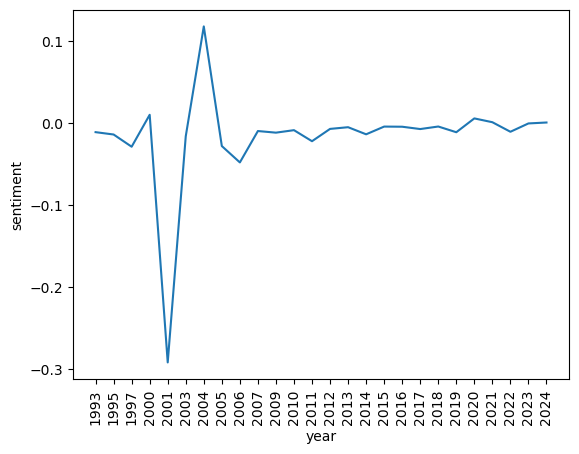

In [25]:
plot = sns.lineplot(data=LIB.groupby('year').agg({'sentiment':'mean'}), x='year', y='sentiment')
plot.tick_params(axis='x', rotation=90)

In [26]:
LIB[LIB.year == '2001']

,album_name,album_title,artist,source_file_path,song_regex,genres,release_date,label,mean_danceability,mean_energy,...,anticipation,disgust,fear,joy,sadness,surprise,trust,sentiment,datelen,year
album_id,,,,,,,,,,,,,,,,,,,,,
4,Amnesiac,Amnesiac,Radiohead,../data/albums/Amnesiac.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'art rock', 'melancholia'...",2001-03-12,XL Recordings,0.408500,0.495100,...,0.008878,0.010771,0.110125,0.012022,0.135939,0.001276,0.012614,-0.083888,10,2001
21,Feel_Good_Lost,Feel Good Lost,Broken Social Scene,../data/albums/Feel_Good_Lost.txt,\[Trackname:\s[^\]]+\],"['alternative rock', 'baroque pop', 'canadian ...",2001-03-06,Arts & Crafts Productions Inc.,0.485333,0.462667,...,0.000000,0.000000,0.499603,0.000000,0.499603,0.000000,0.000000,-0.499603,10,2001


In [27]:
LIB.loc[21].album_term_count

157

It looks like 2001 is a super sad year, but it turns out this is due to there only being two albums in my forpus from this year, and one is mostly instrumental, with two very short, very sad songs. This highlights sensitivity of sentiment analysis to document size.

## Possible Riff 1
Plot sentiment by artist.

In [28]:
sns.set()

Text(0.5, 1.0, 'Artist Emotions')

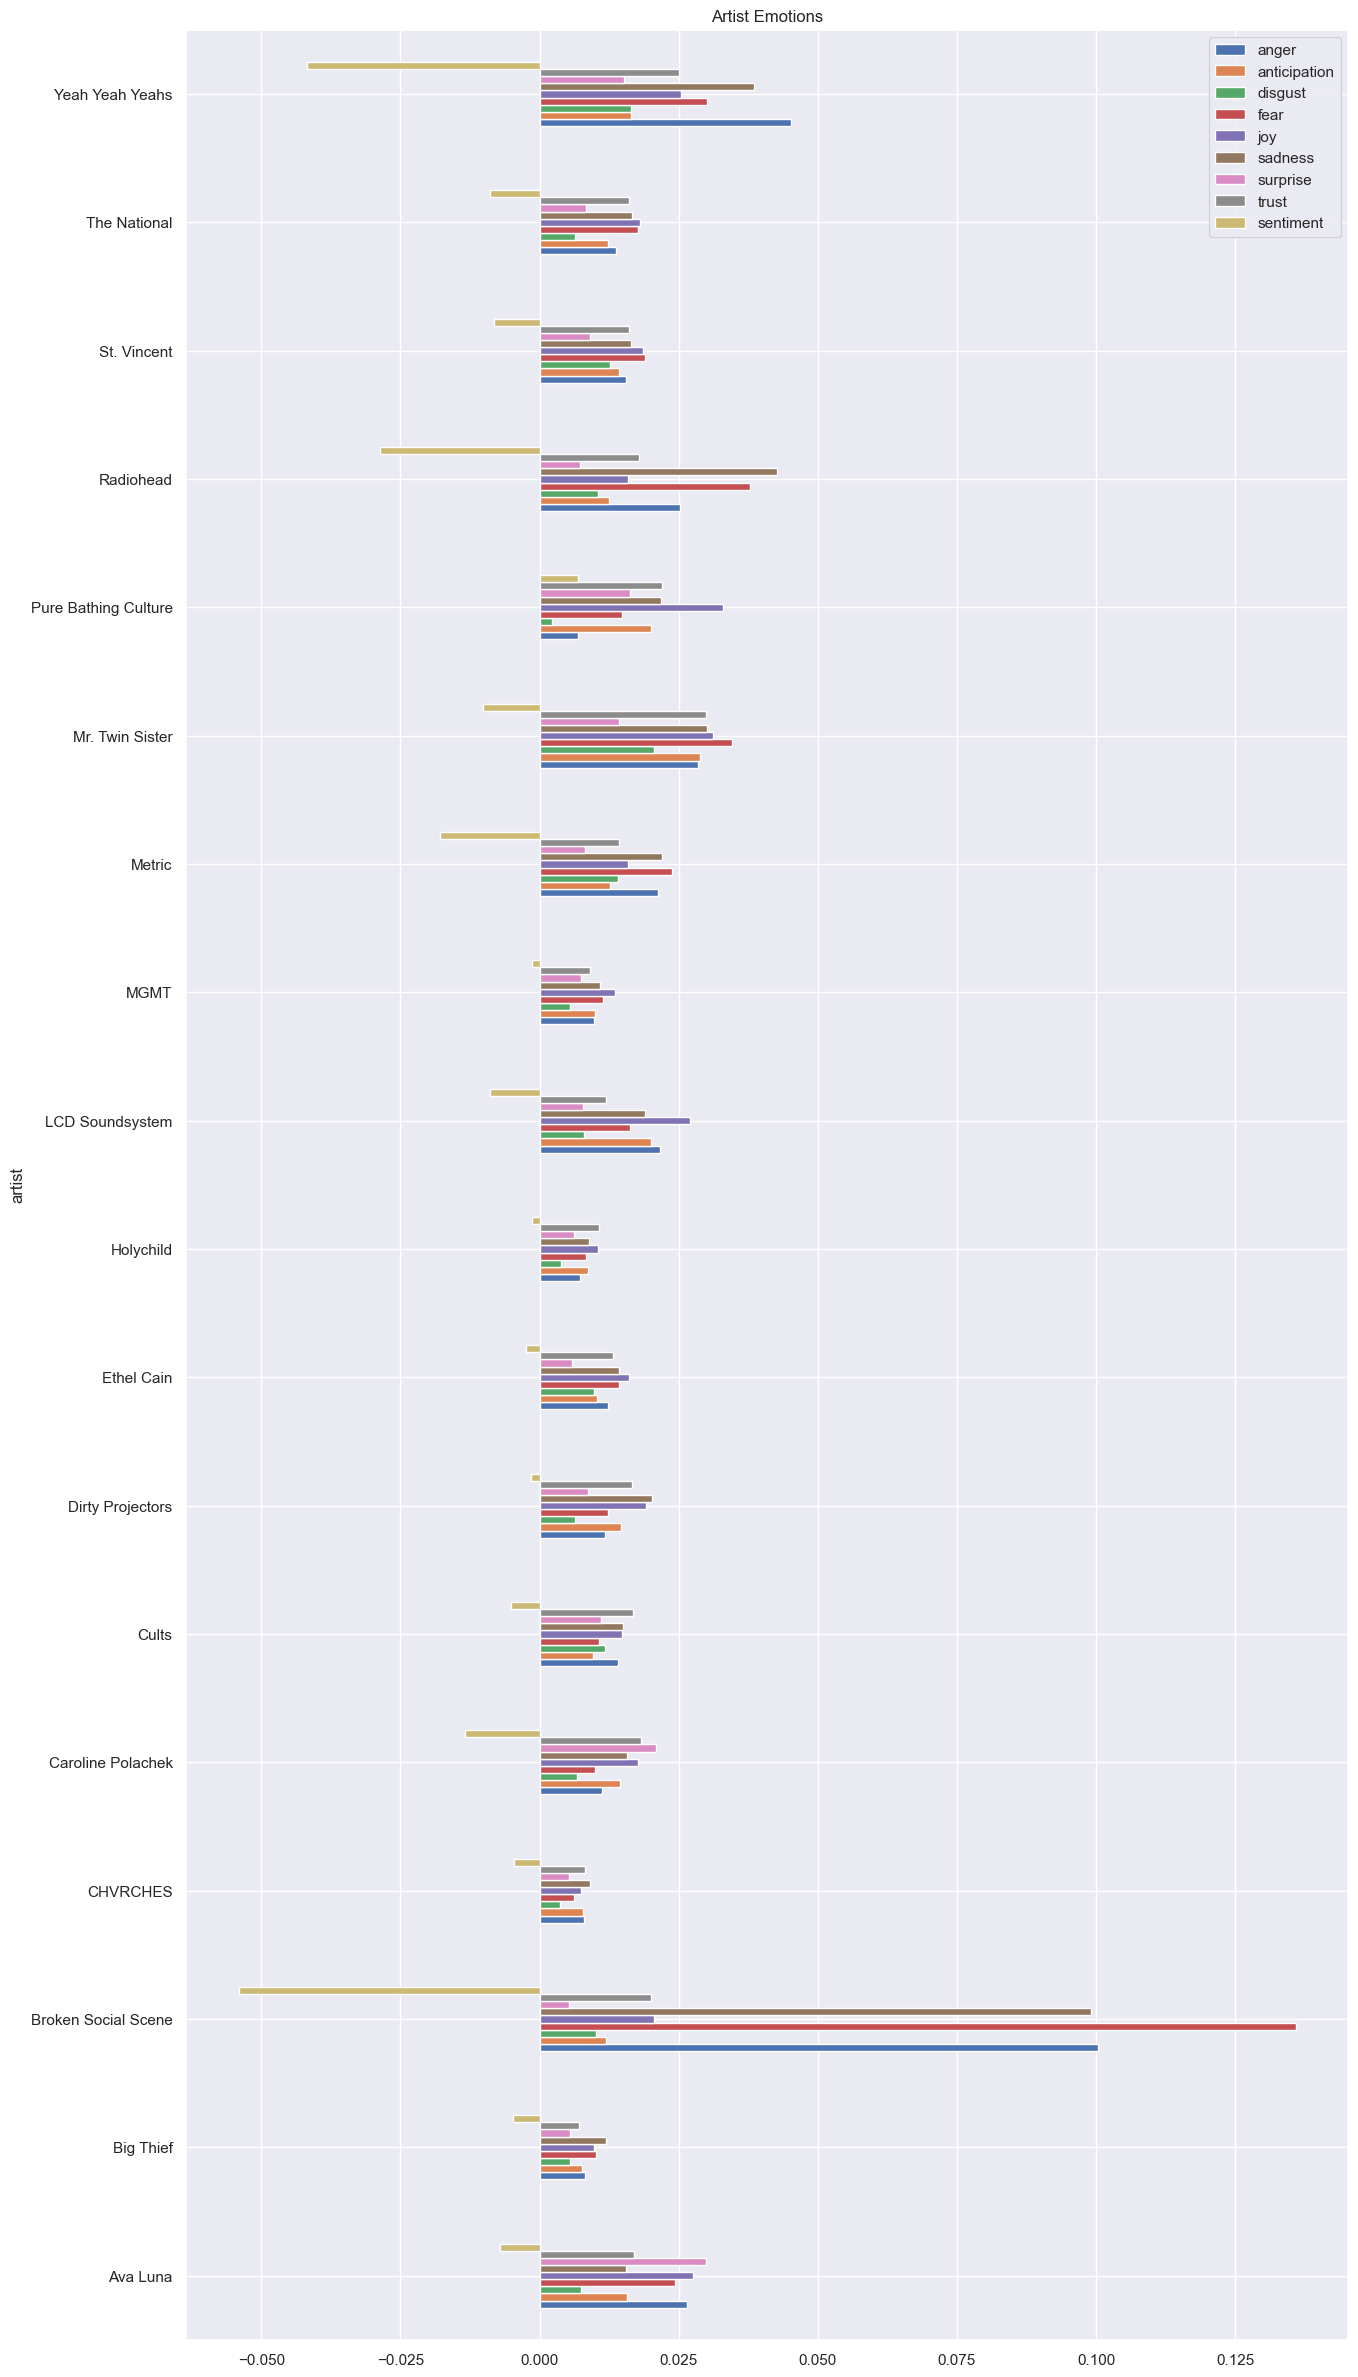

In [51]:
plot = LIB.groupby('artist')[emo_cols].mean().plot.barh(figsize=(15,30))
plot.set_title("Artist Emotions")

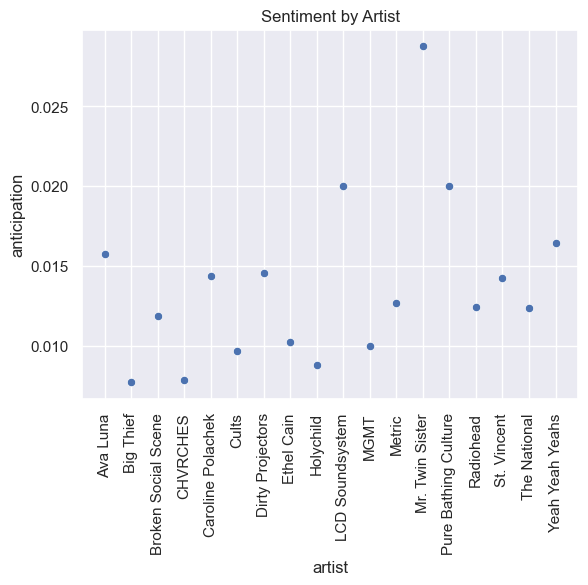

In [30]:
plot = sns.scatterplot(data=LIB.groupby('artist').agg({'anticipation':'mean'}), x='artist', y='anticipation')
plot.set_title('Sentiment by Artist')
plot.tick_params(axis='x', rotation=90)

## Possible Riff 2

* Graph sentiment by artist over albums
    * Do artists have sentiment arcs over albums?

Or

* Graph sentiment by song within album
    * Do albums have sentiment arcs over songs?

## Riff

## Merge `VOCAB` with `BOW_SONG`

In [31]:
BOW_SENT_SONG = BOW_SONG.join(VOCAB_SENT[['max_pos', 'song_dfidf'] + emo_cols], on='term_str', rsuffix='_v').dropna()

In [32]:
BOW_SENT_SONG

n max_pos  song_dfidf  anger  anticipation  \
album_id song_num term_str                                                
0        0        afraid     2      JJ  153.206219    0.0           0.0   
                  beautiful  2      JJ  127.472878    0.0           0.0   
                  favorite   2      JJ   75.736439    0.0           0.0   
                  ill        4     NNP  433.764060    1.0           0.0   
                  love       6      NN  480.125144    0.0           0.0   
...                         ..     ...         ...    ...           ...   
88       8        shit       1      NN  131.311905    1.0           0.0   
         9        bad        1      JJ  209.799505    1.0           0.0   
                  black      6      JJ  226.323498    0.0           0.0   
                  fell       1     VBD  103.075333    0.0           0.0   
                  friend     1      NN  170.150666    0.0           0.0   

                             disgust  fear  joy  sadness  surprise  trust  \
album_id song_num term_str                                                  
0        0        afraid         0.0   1.0  0.0      0.0       0.0    0.0   
                  beautiful      0.0   0.0  1.0      0.0       0.0    0.0   
                  favorite       0.0   0.0  1.0      0.0       0.0    1.0   
                  ill            1.0   1.0  0.0      1.0       0.0    0.0   
                  love           0.0   0.0  1.0      0.0       0.0    0.0   
...                              ...   ...  ...      ...       ...    ...   
88       8        shit           1.0   0.0  0.0      0.0       0.0    0.0   
         9        bad            1.0   1.0  0.0      1.0       0.0    0.0   
                  black          0.0   0.0  0.0      1.0       0.0    0.0   
                  fell           0.0   0.0  0.0      1.0       0.0    0.0   
                  friend         0.0   0.0  1.0      0.0       0.0    1.0   

                             sentiment  
album_id song_num term_str              
0        0        afraid          -1.0  
                  beautiful        1.0  
                  favorite         1.0  
                  ill             -1.0  
                  love             1.0  
...                                ...  
88       8        shit            -1.0  
         9        bad             -1.0  
                  black           -1.0  
                  fell            -1.0  
                  friend           1.0  

[4255 rows x 12 columns]

### Add Album TF-IDF to B for weighting emotions

In [33]:
tfidf_song = TFIDF_SONG.stack().to_frame()

In [34]:
tfidf_song = tfidf_song.reset_index()\
    .rename(columns={'level_2':'term_str', 0:'tfidf'})\
    .set_index(['album_id', 'song_num', 'term_str'])

In [35]:
BOW_SENT_SONG = BOW_SENT_SONG.join(tfidf_song, how='inner')

In [36]:
BOW_SENT_SONG.head()

n max_pos  song_dfidf  anger  anticipation  \
album_id song_num term_str                                                
0        0        afraid     2      JJ  153.206219    0.0           0.0   
                  beautiful  2      JJ  127.472878    0.0           0.0   
                  favorite   2      JJ   75.736439    0.0           0.0   
                  ill        4     NNP  433.764060    1.0           0.0   
                  love       6      NN  480.125144    0.0           0.0   

                             disgust  fear  joy  sadness  surprise  trust  \
album_id song_num term_str                                                  
0        0        afraid         0.0   1.0  0.0      0.0       0.0    0.0   
                  beautiful      0.0   0.0  1.0      0.0       0.0    0.0   
                  favorite       0.0   0.0  1.0      0.0       0.0    1.0   
                  ill            1.0   1.0  0.0      1.0       0.0    0.0   
                  love           0.0   0.0  1.0      0.0       0.0    0.0   

                             sentiment     tfidf  
album_id song_num term_str                        
0        0        afraid          -1.0  0.329476  
                  beautiful        1.0  0.354091  
                  favorite         1.0  0.420758  
                  ill             -1.0  0.319532  
                  love             1.0  0.391939

## Weight emotions by TFIDF

In [37]:
for col in emo_cols:
    BOW_SENT_SONG[col] = BOW_SENT_SONG[col] * BOW_SENT_SONG.tfidf

In [38]:
BOW_SENT_SONG.head()

n max_pos  song_dfidf     anger  anticipation  \
album_id song_num term_str                                                   
0        0        afraid     2      JJ  153.206219  0.000000           0.0   
                  beautiful  2      JJ  127.472878  0.000000           0.0   
                  favorite   2      JJ   75.736439  0.000000           0.0   
                  ill        4     NNP  433.764060  0.319532           0.0   
                  love       6      NN  480.125144  0.000000           0.0   

                              disgust      fear       joy   sadness  surprise  \
album_id song_num term_str                                                      
0        0        afraid     0.000000  0.329476  0.000000  0.000000       0.0   
                  beautiful  0.000000  0.000000  0.354091  0.000000       0.0   
                  favorite   0.000000  0.000000  0.420758  0.000000       0.0   
                  ill        0.319532  0.319532  0.000000  0.319532       0.0   
                  love       0.000000  0.000000  0.391939  0.000000       0.0   

                                trust  sentiment     tfidf  
album_id song_num term_str                                  
0        0        afraid     0.000000  -0.329476  0.329476  
                  beautiful  0.000000   0.354091  0.354091  
                  favorite   0.420758   0.420758  0.420758  
                  ill        0.000000  -0.319532  0.319532  
                  love       0.000000   0.391939  0.391939

## Compute Doc (`SONG`) sentiment 

In [39]:
SONG_SENT = BOW_SENT_SONG.groupby(['album_id', 'song_num'])[emo_cols].mean()

In [40]:
SONG_SENT

anger  anticipation   disgust      fear       joy  \
album_id song_num                                                         
0        0         0.063168      0.026820  0.039941  0.104353  0.164909   
         1         0.329014      1.482722  0.000000  0.000000  1.482722   
1        0         0.172408      0.238352  0.000000  0.577601  0.238352   
         1         0.000000      0.229722  0.000000  0.000000  0.229722   
         2         0.276772      0.590442  0.000000  0.276772  1.723091   
...                     ...           ...       ...       ...       ...   
88       5         0.077282      0.056283  0.077946  0.111295  0.071024   
         6         0.069188      0.020316  0.020316  0.105837  0.039510   
         7         0.149995      0.054993  0.064852  0.119708  0.088319   
         8         0.174268      0.000000  0.083373  0.000000  0.062213   
         9         0.097310      0.000000  0.097310  0.097310  0.107418   

                    sadness  surprise     trust  sentiment  
album_id song_num                                           
0        0         0.063168  0.050047  0.071655   0.060556  
         1         1.068497  0.000000  0.000000   0.414225  
1        0         0.460761  0.000000  0.238352  -0.339248  
         1         0.055461  0.049868  0.419082  -0.015100  
         2         0.276772  1.314720  0.998813   1.446319  
...                     ...       ...       ...        ...  
88       5         0.133497  0.054804  0.051200  -0.060304  
         6         0.093503  0.053830  0.021664  -0.092261  
         7         0.087201  0.039360  0.071712  -0.056421  
         8         0.090895  0.000000  0.000000  -0.112055  
         9         0.788588  0.000000  0.107418  -0.681170  

[891 rows x 9 columns]

## Add `SONG_SENT` to `SONG_LIB`

In [41]:
SONG_LIB = SONG_LIB.join(SONG_SENT)

## Plot song sentiment and danceability

In [42]:
SONG_LIB.columns

Index(['title', 'json_path', 'artist', 'album', 'genres', 'release_date',
       'label', 'track_number', 'duration_ms', 'audio_information', 'lyrics',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'time_signature', 'album_title', 'genre', 'anger', 'anticipation',
       'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'sentiment'],
      dtype='object')

In [58]:
px.scatter(SONG_LIB, x='danceability', y='sentiment', color='artist', title='Song Sentiment vs. Danceability', hover_data='title')

In [54]:
px.scatter(SONG_LIB, x='danceability', y='joy', color='artist', title='Song Joy vs. Danceability', hover_data='title')

In [55]:
px.scatter(SONG_LIB, x='danceability', y='sadness', color='artist', title='Song Sadness vs. Danceability', hover_data='title')

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

## Riff
Graph sentiment over albums

In [44]:
px.line(SONG_LIB.query(f'artist == "St. Vincent"'), x='track_number', y='sentiment', color='album',
        title=f'Sentiment Over Songs for St. Vincent')

In [45]:
px.line(SONG_LIB.query(f'artist == "Radiohead"'), x='track_number', y='sentiment', color='album',
        title=f'Sentiment Over Songs for Radiohead')

In [46]:
px.line(SONG_LIB.query(f'artist == "The National"'), x='track_number', y='sentiment', color='album',
        title=f'Sentiment Over Songs for The National')

## Save tables

In [47]:
VOCAB_SENT.to_csv('../tables/VOCAB_SENT.csv', sep='|')
BOW_SENT_ALBUM.to_csv('../tables/BOW_SENT_ALBUM.csv', sep='|')
ALBUM_SENT.to_csv('../tables/ALBUM_SENT.csv', sep='|')
BOW_SENT_SONG.to_csv('../tables/BOW_SENT_SONG.csv', sep='|')
SONG_SENT.to_csv('../tables/SONG_SENT.csv', sep='|')